In [1]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
import snappy
import numpy as np
import random as rn
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(4321)
rn.seed(4321)
tf.random.set_seed(4321)

In [2]:
water_veg_mask = np.load(r'D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\water_mask.npy')

In [3]:
unique, counts = np.unique(water_veg_mask, return_counts=True)
print(unique, counts)
water_veg_mask = water_veg_mask.flatten()

[0 1] [639757  14724]


In [4]:
product_path = r'D:\Engi_Books\CDSAML\reflectance\data\subset_0_of_S1S2_collocated.dim'

In [5]:
product = snappy.ProductIO.readProduct(product_path)
width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()

In [6]:
# B2 = product.getBand('B2')
# B3 = product.getBand('B3_S')
# B4 = product.getBand('B4_S')
# B5 = product.getBand('B5')
# B6 = product.getBand('B6')
# B7 = product.getBand('B7')
# B8 = product.getBand('B8_S')
# B8A = product.getBand('B8A')
B11 = product.getBand('B11_S')
B12 = product.getBand('B12_S')

In [7]:
# B2_pixels = np.zeros(width * height, np.float32)
# B2.readPixels(0,0,width,height,B2_pixels)
# # B2_pixels.flatten()

# B3_pixels = np.zeros(width * height, np.float32)
# B3.readPixels(0,0,width,height,B3_pixels)
# B3_pixels.flatten()

# B4_pixels = np.zeros(width * height, np.float32)
# B4.readPixels(0,0,width,height,B4_pixels)
# # B4_pixels.flatten()

# B5_pixels = np.zeros(width * height, np.float32)
# B5.readPixels(0,0,width,height,B5_pixels)

# B6_pixels = np.zeros(width * height, np.float32)
# B6.readPixels(0,0,width,height,B6_pixels)

# B7_pixels = np.zeros(width * height, np.float32)
# B7.readPixels(0,0,width,height,B7_pixels)

# B8_pixels = np.zeros(width * height, np.float32)
# B8.readPixels(0,0,width,height,B8_pixels)
# # B8_pixels.flatten()

# B8A_pixels = np.zeros(width * height, np.float32)
# B8A.readPixels(0,0,width,height,B8A_pixels)

B11_pixels = np.zeros(width * height, np.float32)
B11.readPixels(0,0,width,height,B11_pixels)

B12_pixels = np.zeros(width * height, np.float32)
B12.readPixels(0,0,width,height,B12_pixels)

array([0.1214, 0.1363, 0.1363, ..., 0.2204, 0.2131, 0.2131], dtype=float32)

In [8]:
df = pd.DataFrame({
#                 'B2':B2_pixels, 
#                    'B3': B3_pixels,
#                    'B4': B4_pixels,
#                    'B5': B5_pixels,
#                    'B6': B6_pixels,
#                    'B7': B7_pixels,
#                    'B8': B8_pixels,
#                    'B8A': B8A_pixels,
                   'B11': B11_pixels,
                   'B12': B12_pixels,
                    'Y':water_veg_mask})
#df.drop(df[df.X == 0].index,inplace=True)

In [9]:
# x_cols = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
x_cols = ['B11', 'B12']

In [10]:
sample_0 = df.query('Y == 0').sample(counts[1])
sample_1 = df.query('Y == 1').sample(counts[1])

In [11]:
sampled_df = pd.concat([sample_0, sample_1],keys=['B11', 'B12', 'Y'])
# sampled_df = pd.DataFrame()
# sampled_df = sampled_df.append(sample_0, ignore_index = True).append(sample_1, ignore_index = True)
sampled_df = sampled_df.sample(frac=1).reset_index(drop=True)

In [12]:
# X_train,X_test,y_train,y_test = train_test_split(sampled_df[x_cols],sampled_df['Y'],test_size=0.2,random_state=4321, stratify = sampled_df['Y'])

In [13]:
X_train,X_test,y_train,y_test = train_test_split(df[x_cols],df['Y'],test_size=0.2,random_state=4321, stratify = df['Y'])

In [14]:
# X_train.reset_index(drop=True, inplace=True)
# X_test.reset_index(drop=True, inplace=True)

In [15]:
# X_train

In [16]:
def show_confusion_matrix(y_test, y_pred, score):    
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 15);
    return cm

In [17]:
def get_miou(cm):
    col_sums = cm.sum(axis=0)
    row_sums = cm.sum(axis=1)
    iou = 0.0
    c = 0
    for i in range(len(cm)):
        tp = cm[i,i]
        denominator = (col_sums[i]+row_sums[i] - tp)
        if denominator != 0:
            c +=1
            iou += tp/denominator
    return iou/c

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +
                                  (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=1.1):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [19]:
# y_train= to_categorical(y_train,num_classes=2)
# y_test= to_categorical(y_test,num_classes=2)
# # y_val = to_categorical(y_val,num_classes=3)
# print("Shape of y_train",y_train.shape)
# print("Shape of y_test",y_test.shape)
# print("Shape of y_val",y_val.shape)

In [20]:
# y_train = y_train.astype('int64')
# y_test = y_test.astype('int64')


In [21]:
X_val = pd.DataFrame({
#                 'B2':B2_pixels, 
#                    'B3': B3_pixels,
#                    'B4': B4_pixels,
#                    'B5': B5_pixels,
#                    'B6': B6_pixels,
#                    'B7': B7_pixels,
#                    'B8': B8_pixels,
#                    'B8A': B8A_pixels,
                   'B11': B11_pixels,
                   'B12': B12_pixels,
                    })
X_val.shape
# y_val = to_categorical(water_veg_mask,num_classes=2)
y_val = water_veg_mask

In [22]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

In [23]:
model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),
#             tf.keras.layers.experimental.preprocessing.Normalization(),
            tf.keras.layers.Dense(32, activation="relu"),
#             tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dropout(0.4),
#             tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(1, activation="sigmoid")
            
            
        ]
        )

In [24]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
#     min_delta=0.001, 
    restore_best_weights=True
)

In [25]:
mc = ModelCheckpoint(filepath = r'D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\9_b1112_ANN_lr_1em4.h5',
                     monitor='val_mean_io_u',
                     mode='max',
                     verbose=1,
                     save_best_only=True)

In [26]:
# model.compile(
#     loss=[focal_tversky_loss],
#     optimizer=tf.keras.optimizers.Adam(9e-5),
#     metrics=[tf.keras.metrics.MeanIoU(2)],
# )

model.compile(
    loss=[tf.keras.losses.BinaryCrossentropy()],
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [27]:
%%time
with tf.device('/gpu:0'):
    history_keras = model.fit(
        X_train,y_train,
        validation_data=(X_test,y_test),
        batch_size=128,
        epochs=500,
        callbacks = [es]
        )

Epoch 1/500
4091/4091 [==============================] - 22s 5ms/step - loss: 0.1689 - binary_accuracy: 0.9775 - val_loss: 0.0579 - val_binary_accuracy: 0.9775
Epoch 2/500
4091/4091 [==============================] - 23s 6ms/step - loss: 0.0343 - binary_accuracy: 0.9869 - val_loss: 0.0137 - val_binary_accuracy: 0.9967
Epoch 3/500
4091/4091 [==============================] - 21s 5ms/step - loss: 0.0139 - binary_accuracy: 0.9963 - val_loss: 0.0116 - val_binary_accuracy: 0.9967
Epoch 4/500
4091/4091 [==============================] - 21s 5ms/step - loss: 0.0126 - binary_accuracy: 0.9964 - val_loss: 0.0113 - val_binary_accuracy: 0.9967
Epoch 5/500
4091/4091 [==============================] - 21s 5ms/step - loss: 0.0123 - binary_accuracy: 0.9964 - val_loss: 0.0110 - val_binary_accuracy: 0.9967
Epoch 6/500
4091/4091 [==============================] - 21s 5ms/step - loss: 0.0122 - binary_accuracy: 0.9965 - val_loss: 0.0108 - val_binary_accuracy: 0.9967
Epoch 7/500
4091/4091 [=================

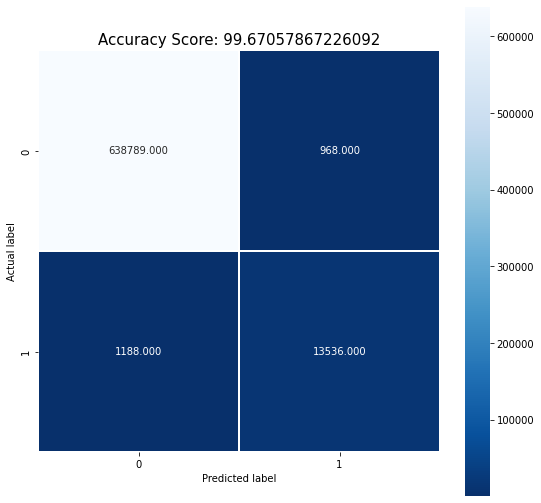

In [28]:
# clf_y_pred = model.predict(X_val)
# y_label=np.argmax(y_val,axis=1)
# length=len(clf_y_pred)
# predict_label_ak=np.argmax(clf_y_pred,axis=1)

# accuracy_ak=np.sum(y_label==predict_label_ak)/length * 100 

# cm = show_confusion_matrix(y_test = y_label, y_pred = predict_label_ak, score = accuracy_ak)

clf_y_pred = model.predict(X_val)
clf_y_pred = [1 if x > 0.5 else 0 for x in clf_y_pred]
clf_y_pred = np.array(clf_y_pred)
# y_label=np.argmax(y_val,a)
length=len(clf_y_pred)
# predict_label_ak=np.argmax(clf_y_pred,axis=1)

accuracy_ak=np.sum(y_val==clf_y_pred)/length * 100 

cm = show_confusion_matrix(y_test = y_val, y_pred = clf_y_pred, score = accuracy_ak)

In [29]:
ann_miou = get_miou(cm)
print(ann_miou)

0.9296206829783245


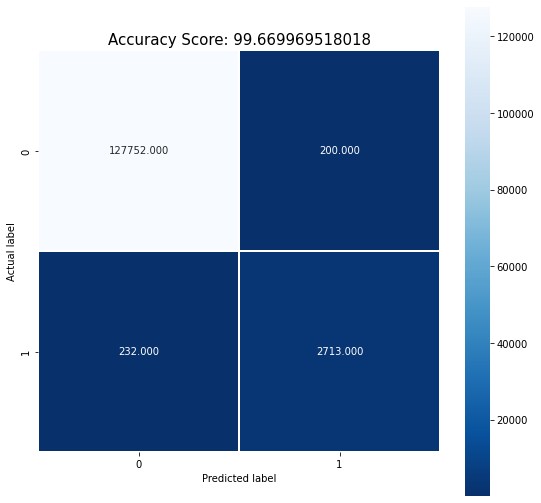

In [30]:
# clf_y_pred = model.predict(X_test)
# y_label=np.argmax(y_test,axis=1)
# length=len(clf_y_pred)
# predict_label_ak=np.argmax(clf_y_pred,axis=1)

# accuracy_ak=np.sum(y_label==predict_label_ak)/length * 100 

# cm = show_confusion_matrix(y_test = y_label, y_pred = predict_label_ak, score = accuracy_ak)

clf_y_pred = model.predict(X_test)
clf_y_pred = [1 if x > 0.5 else 0 for x in clf_y_pred]
clf_y_pred = np.array(clf_y_pred)
# y_label=np.argmax(y_test,axis=1)
length=len(clf_y_pred)
# predict_label_ak=np.argmax(clf_y_pred,axis=1)

accuracy_ak=np.sum(y_test==clf_y_pred)/length * 100 

cm = show_confusion_matrix(y_test = y_test, y_pred = clf_y_pred, score = accuracy_ak)

In [31]:
ann_miou = get_miou(cm)
print(ann_miou)

0.9296344771481615


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.save(r'D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\9_B1112_ANN_S_BC')

INFO:tensorflow:Assets written to: D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\9_B1112_ANN_S_BC\assets


INFO:tensorflow:Assets written to: D:\workspace\jupyterNotebooks\Remote Sensing\Water-Segmentation\data\9_B1112_ANN_S_BC\assets
